In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="5"
import tensorflow as tf
physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [3]:
import tensorflow as tf

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
# 画像サイズ
img_size = 128
channels = 3
img_shape = (img_size, img_size, channels)

# 学習の設定
batch_size = 32
epochs = 100

画像のデータジェネレータ

In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def preprocessing_function(x):
    return x / 127.5 - 1

A_datagen = ImageDataGenerator(width_shift_range=0.1,
                 height_shift_range=0.1,
                 preprocessing_function = preprocessing_function
                 )
B_datagen = ImageDataGenerator(width_shift_range=0.1,
                 height_shift_range=0.1,
                 preprocessing_function = preprocessing_function
                 )

# apple画像へのpathを渡す
A_generator = A_datagen.flow_from_directory('8CycleGAN/apple2orange/train/trainA',
                                            class_mode=None,
                                            batch_size=batch_size,
                                            target_size=(img_size, img_size), 
                                            color_mode='rgb')

# orange画像へのpathを渡す
B_generator = B_datagen.flow_from_directory('8CycleGAN/apple2orange/train/trainB',
                                            class_mode=None, 
                                            batch_size=batch_size,
                                            target_size=(img_size, img_size), 
                                            color_mode='rgb')

Found 996 images belonging to 2 classes.
Found 1019 images belonging to 2 classes.


モデルの作成

In [6]:
from tensorflow.keras.initializers import RandomNormal

kernel_init = RandomNormal(mean=0.0, stddev=0.02)
gamma_init = RandomNormal(mean=0.0, stddev=0.02)

In [7]:
import tensorflow.keras.backend as K

import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Flatten, Reshape, UpSampling2D, BatchNormalization, Conv2D, Activation, Dropout, Conv2DTranspose
from tensorflow.keras.layers import LeakyReLU, LayerNormalization, Concatenate
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam

from tensorflow_addons.layers import InstanceNormalization


patch_size = int(img_size/2**4)
patch_shape = (patch_size, patch_size, 1)


def build_generator(filters=32):
    
    model_input = Input(shape=img_shape)
    
    # Encoder
    x = Conv2D(filters, kernel_size=4, strides=2, padding="same", use_bias=False, kernel_initializer=kernel_init)(model_input)
    x = LeakyReLU(0.2)(x)
    x1 = InstanceNormalization(gamma_initializer=gamma_init)(x)
    
    x = Conv2D(filters*2, kernel_size=4, strides=2, padding="same", use_bias=False, kernel_initializer=kernel_init)(x1)
    x = LeakyReLU(0.2)(x)
    x2 = InstanceNormalization(gamma_initializer=gamma_init)(x)
    
    x = Conv2D(filters*4, kernel_size=4, strides=2, padding="same", use_bias=False, kernel_initializer=kernel_init)(x2)
    x = LeakyReLU(0.2)(x)
    x3 = InstanceNormalization()(x)  
    
    x = Conv2D(filters*8, kernel_size=4, strides=2, padding="same", use_bias=False, kernel_initializer=kernel_init)(x3)
    x = LeakyReLU(0.2)(x)
    x4 = InstanceNormalization(gamma_initializer=gamma_init)(x)

    
    # Decoder
    x = UpSampling2D((2, 2))(x4)
    x = Conv2D(filters*4, kernel_size=4, strides=1, padding="same", use_bias=False, kernel_initializer=kernel_init)(x)
    x = LeakyReLU(0.2)(x)
    x = InstanceNormalization(gamma_initializer=gamma_init)(x)  
    x = Concatenate()([x, x3])
    
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(filters*2, kernel_size=4, strides=1, padding="same", use_bias=False, kernel_initializer=kernel_init)(x)
    x = LeakyReLU(0.2)(x)
    x = InstanceNormalization(gamma_initializer=gamma_init)(x)  
    x = Concatenate()([x, x2])
    
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(filters, kernel_size=4, strides=1, padding="same", use_bias=False, kernel_initializer=kernel_init)(x)
    x = LeakyReLU(0.2)(x)
    x = InstanceNormalization(gamma_initializer=gamma_init)(x)  
    x = Concatenate()([x, x1])
    
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(3, kernel_size=4, strides=1, padding="same", activation="tanh", use_bias=False, kernel_initializer=kernel_init)(x)

    model = Model(model_input, x)
    
    model.summary()
    
    return model


def build_discriminator(filters=64):
    
    model_input = Input(shape=img_shape)
    
    x = Conv2D(filters, kernel_size=4, strides=2, padding="same", use_bias=False, kernel_initializer=kernel_init)(model_input)
    x = LeakyReLU(0.2)(x)
    
    x = Conv2D(filters*2, kernel_size=4, strides=2, padding="same", use_bias=False, kernel_initializer=kernel_init)(x)
    x = LeakyReLU(0.2)(x)
    x = InstanceNormalization(gamma_initializer=gamma_init)(x)
    
    x = Conv2D(filters*4, kernel_size=4, strides=2, padding="same", use_bias=False, kernel_initializer=kernel_init)(x)
    x = LeakyReLU(0.2)(x)
    x = InstanceNormalization(gamma_initializer=gamma_init)(x)  
    
    x = Conv2D(filters*8, kernel_size=4, strides=2, padding="same", use_bias=False, kernel_initializer=kernel_init)(x)
    x = LeakyReLU(0.2)(x)
    x = InstanceNormalization(gamma_initializer=gamma_init)(x)
    
    x = Conv2D(1, kernel_size=4, strides=1, padding="same", use_bias=False, kernel_initializer=kernel_init)(x)
    
    model = Model(model_input, x)
    
    model.summary()
    
    return model

In [8]:
from tensorflow.keras import optimizers

optimizer = optimizers.Adam(learning_rate=0.0002, beta_1=0.5)

lambda_cycyle = 10.
lambda_id = 5.

D_A = build_discriminator()
D_B = build_discriminator()

D_A.compile(loss='mse', optimizer=optimizer, metrics=['accuracy'])
D_B.compile(loss='mse', optimizer=optimizer, metrics=['accuracy'])

G_AB = build_generator()
G_BA = build_generator()

# 入力画像のためのプレースホルダー
real_A = Input(shape=img_shape)
real_B = Input(shape=img_shape)

# 生成器一回でできるフェイク画像
fake_A = G_BA(real_B)
fake_B = G_AB(real_A)

# サイクル整合性のための再構成
cycle_A = G_BA(fake_B)
cycle_B = G_AB(fake_A)

# 同一性
same_A = G_BA(real_A)
same_B = G_AB(real_B)

# fake画像に対する識別器の出力
disc_fake_A = D_A(fake_A)
disc_fake_B = D_B(fake_B)

D_A.trainable = False
D_B.trainable = False

cycle_gan = Model(inputs=[real_A, real_B],
                 outputs=[disc_fake_A, disc_fake_B,
                         cycle_A, cycle_B,
                         same_A, same_B])

cycle_gan.compile(loss=['mse', 'mse', 'mae', 'mae', 'mae', 'mae'],
                 loss_weights=[1, 1, lambda_cycyle, lambda_cycyle, lambda_id, lambda_id],
                 optimizer=optimizer)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 64, 64, 64)        3072      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 64, 64, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 128)       131072    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 32, 32, 128)       0         
_________________________________________________________________
instance_normalization (Inst (None, 32, 32, 128)       256       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 256)       524288

学習

In [9]:
disc_A_loss_hoistory = []
disc_B_loss_hoistory = []
disc_loss_hoistory = []

gen_loss_hoistory = []


def train(epochs, iterations_per_epochs, batch_size=128):
    
    valid = np.ones((batch_size,) + patch_shape)
    fake = np.zeros((batch_size,) + patch_shape)
    
    for epoch in range(epochs):
        for i in range(iterations_per_epochs):
            
            batch_A = next(A_generator)
            batch_B = next(B_generator)
            
            # generatorのミニバッチの余りの処理。もっと実装を賢くし直した方がいい
            batch_size_modified = batch_size
            if batch_A.shape[0]!=batch_B.shape[0]:
                batch_size_modified = min(batch_A.shape[0], batch_B.shape[0])
                
            batch_A = batch_A[:batch_size_modified]
            batch_B = batch_B[:batch_size_modified]
            
            fake_B = G_AB.predict(batch_A)
            fake_A = G_BA.predict(batch_B)
            
            disc_A_loss_real = D_A.train_on_batch(batch_A, valid[:batch_size_modified], use_multiprocessing=True, workers=20)
            disc_A_loss_fake = D_A.train_on_batch(fake_A, fake[:batch_size_modified], use_multiprocessing=True, workers=20)
            
            disc_A_loss = 0.5 * np.add(disc_A_loss_real, disc_A_loss_fake)
            disc_A_loss_hoistory.append(disc_A_loss)
            
            disc_B_loss_real = D_B.train_on_batch(batch_B, valid[:batch_size_modified])
            disc_B_loss_fake = D_B.train_on_batch(fake_B, fake[:batch_size_modified])
            
            disc_B_loss = 0.5 * np.add(disc_B_loss_real, disc_B_loss_fake)
            disc_B_loss_hoistory.append(disc_B_loss)
            
            d_loss = 0.5 * np.add(disc_A_loss, disc_B_loss)
            disc_loss_hoistory.append(d_loss)
            
            g_loss = cycle_gan.train_on_batch([batch_A, batch_B],
                                              [valid[:batch_size_modified], valid[:batch_size_modified],
                                               batch_A, batch_B,
                                               batch_A, batch_B], use_multiprocessing=True, workers=20)
            gen_loss_hoistory.append(g_loss)
            
            if i==0:
                print('d loss, g loss:', d_loss[0],  g_loss)

In [10]:
iterations_per_epochs = 995//batch_size

train(epochs=epochs, iterations_per_epochs=iterations_per_epochs, batch_size=batch_size)

d loss, g loss: 0.5000236985688389 [19.64173698425293, 0.9842355251312256, 0.9833275079727173, 0.6049360036849976, 0.5735037326812744, 0.6064983606338501, 0.5714569091796875]
d loss, g loss: 0.1248912550508976 [13.12651252746582, 0.5463928580284119, 0.6215245127677917, 0.49053120613098145, 0.3180083930492401, 0.48285144567489624, 0.2917885184288025]
d loss, g loss: 0.16639295779168606 [11.448102951049805, 0.691356360912323, 0.8062435984611511, 0.3096446096897125, 0.3631912171840668, 0.29881367087364197, 0.3456152677536011]
d loss, g loss: 0.1686781644821167 [10.0831937789917, 0.8818854689598083, 0.9436867237091064, 0.2847992777824402, 0.28057029843330383, 0.26402589678764343, 0.25675931572914124]
d loss, g loss: 0.21368436515331268 [11.175945281982422, 0.6888765692710876, 0.6313772201538086, 0.3164035677909851, 0.37435224652290344, 0.27269405126571655, 0.3169326186180115]
d loss, g loss: 0.15499775856733322 [9.421178817749023, 0.8160649538040161, 0.6745527982711792, 0.25966548919677734

学習後のモデル（`G_AB, G_BA`）にテスト画像を入れて、うまく変換できているかを確認してみる。画素値が`[-1, 1]`に規格化されていることに注意。

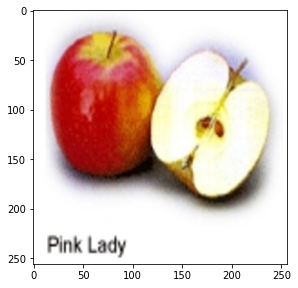

In [19]:
# 画像を確認してみる
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

img1_path = os.path.join("8CycleGAN/apple2orange/test/testA/img/n07740461_10011.jpg")

img1 = Image.open(img1_path)

fig = plt.figure(figsize=(10,20))
ax1 = fig.add_subplot(121)
ax1.imshow(img1)

In [124]:
#generatorモデルでランダムノイズ(20,32)を形状(20,32,32,3)の画像にマッピング
generated_imagesA =(G_AB.predict(A_generator)+1)/2
generated_imagesB =(G_BA.predict(B_generator)+1)/2

generated_imagesAA =(G_BA.predict(A_generator)+1)/2
generated_imagesBB =(G_AB.predict(B_generator)+1)/2

# #生成された画像を1つずつ保存(generated_frog0.ping, generated_frog100.ping,..., generated_frog9900.ping)
# img = image.array_to_img(generated_images[0] * 128., scale=False)
# img.save(os.path.join(save_dir, 'generated_frog' + str(step) + '.png'))

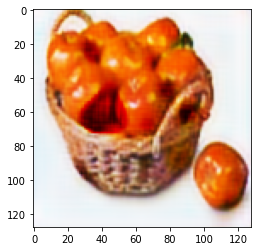

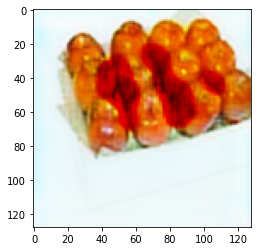

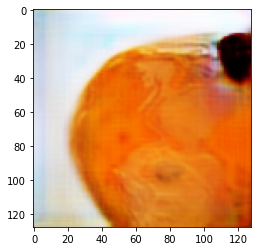

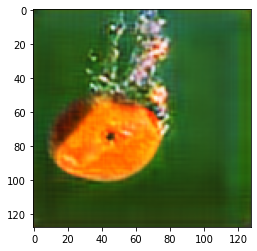

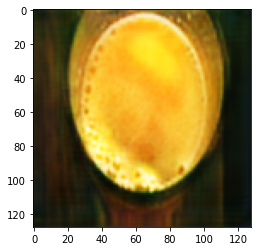

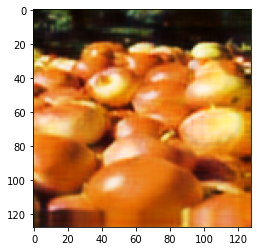

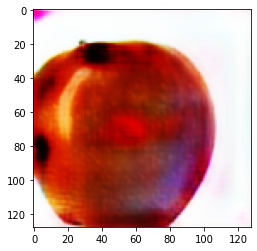

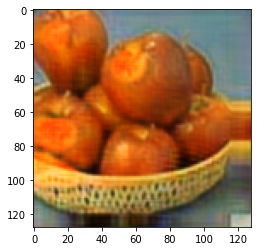

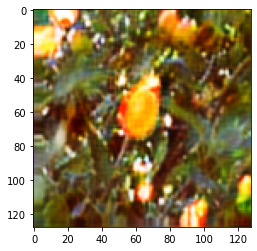

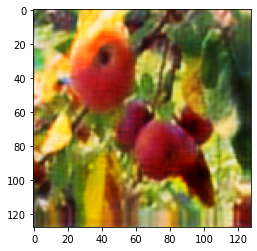

In [122]:
for i in range(10):
    plt.imshow(generated_imagesA[i])
    plt.show()

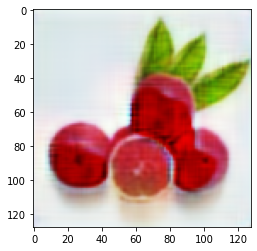

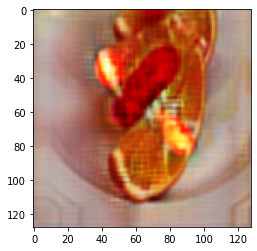

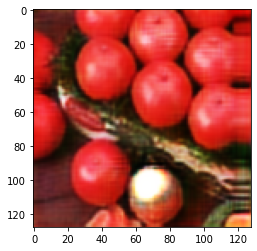

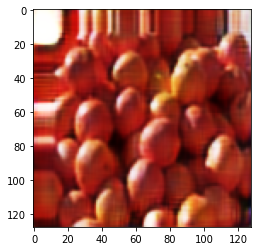

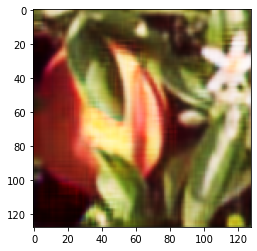

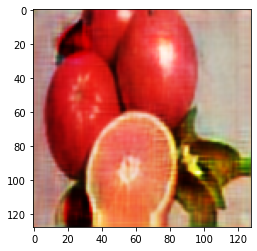

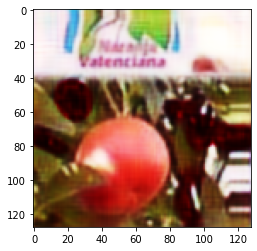

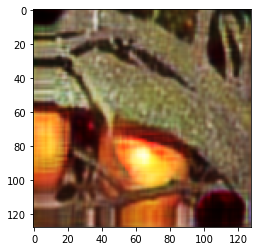

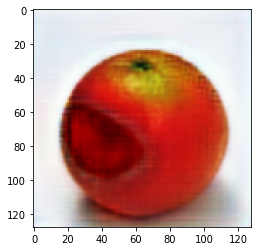

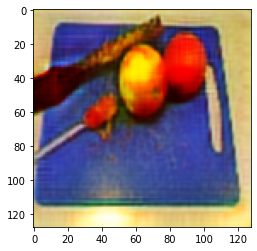

In [123]:
for i in range(10):
    plt.imshow(generated_imagesB[i])
    plt.show()

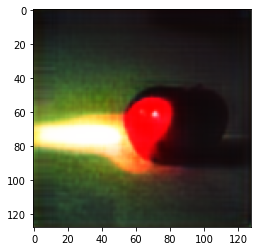

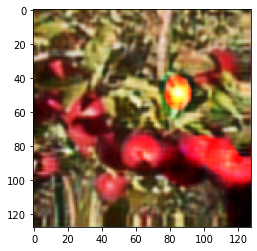

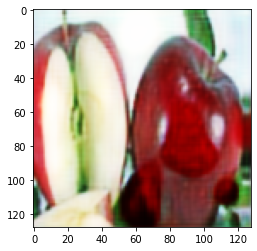

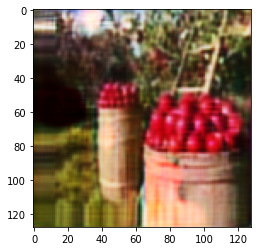

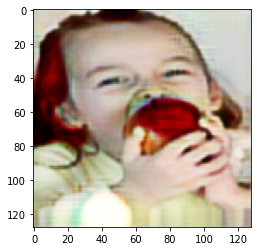

In [125]:
for i in range(5):
    plt.imshow(generated_imagesAA[i])
    plt.show()

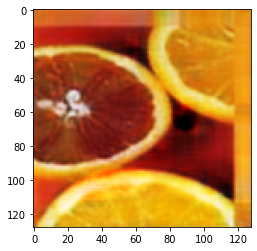

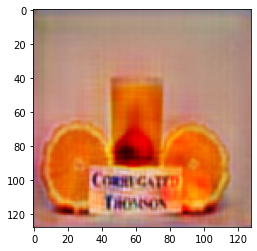

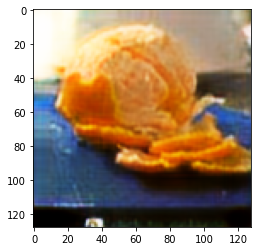

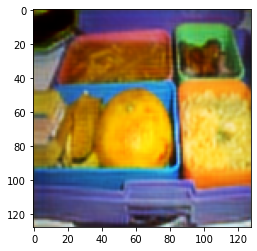

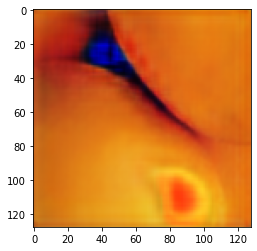

In [126]:
for i in range(5):
    plt.imshow(generated_imagesBB[i])
    plt.show()